In [ ]:
#pip install tensorflow

In [ ]:
# Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix


# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [ ]:
TIME_STEP = 15
JUMP_STEP = 1
NUM_FEATURES = 5
THRESHOLD = 1
# usando apenas o Close


## Importar a Base de Dados

In [ ]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 2, 8, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [ ]:
def selecionaValores(df, jump_step):
  return df[0::jump_step]

df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [ ]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

# Adição da coluna de variação
df['TargetChange'] = df.Close.shift(-1) - df['Close']
# Adição da coluna de variação percentual
df['TargetVariation'] = (df['TargetChange'] / df['Close'])*100
# Adição da coluna de classificação
df['TargetClass'] = [0 if df.TargetVariation[i] >= THRESHOLD else 1 if df.TargetVariation[i] <= (-THRESHOLD) else 2 for i in range(len(df))]
# Adição da coluna de Valor Final
df['TargetClose'] = df['Close'].shift(-1)

# df.pop('TargetVariation')
# df.pop('TargetClass')
# df.pop('TargetClose')
data.dropna(inplace=True)
data.reset_index(inplace = True)


In [ ]:
df.head()

,Open,High,Low,Close,Volume,TargetChange,TargetVariation,TargetClass,TargetClose
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,-32.894013,-7.192558,1,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-29.644012,-6.984264,1,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,14.108002,3.573492,0,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,-10.082978,-2.465855,1,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,3.330994,0.835210,2,402.152008


In [ ]:
#plt.plot(df.index, df['Close'])

In [ ]:
# Separa as Features do Valor Final
# Separa X de Y e Retira a última linha
y_array = np.array(df.TargetClass)[:-1].copy()
#df.pop('Open')
#df.pop('High')
#df.pop('Low')
#df.pop('Volume')
df.pop('TargetChange')
df.pop('TargetVariation')
df.pop('TargetClass')
df.pop('TargetClose')
x_array = np.array(df)[:-1].copy()


In [ ]:
#Transforma os dados para suavizar as variações em escala absoluta
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled_data = scaler.fit_transform(x_array)
#Talvez usar apenas transform em teste e não fit_transform

In [ ]:
# n = timestep = 3 no exemplo abaixo
# [[[1], [2], [3]]] => [4]
# [[[2], [3], [4]]] => [5]
# [[[3], [4], [5]]] => [6]

def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(x) - time_step):
    row = [e for e in x[i : i + time_step]]
    input.append(row)
    output.append([y[i]])
  return np.array(input), np.array(output)

x_data, y_data = createDataset(x_scaled_data, y_array, TIME_STEP)
print(df.shape)
print(x_data.shape, y_data.shape)

(3067, 5)
(3051, 15, 5) (3051, 1)


In [ ]:
print("Data")
data_count = [0, 0, 0]
for i in range(y_data.shape[0]):
  if(y_data[i]==1):
    data_count[1]+=1
  elif(y_data[i]==2):
    data_count[2]+=1
  else:
    data_count[0]+=1
print(data_count)

Data
[1049, 871, 1131]


## Preparar os dados para Treino e Teste



In [ ]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(df-1) - TIME_STEP
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

x_train, y_train = x_data[: train_size], y_data[: train_size]
x_val, y_val = x_data[train_size : (train_size + validation_size)], y_data[train_size : (train_size + validation_size)]
x_test, y_test = x_data[(train_size + validation_size) :], y_data[(train_size + validation_size) :]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

#[samples, time steps, features]

(2136, 15, 5) (2136, 1)
(305, 15, 5) (305, 1)
(610, 15, 5) (610, 1)


#### Imprime informações sobre os dados

In [ ]:
# Quantos valores temos de cada classe
# Lateralizou, Subiu, Caiu

print("Train")
train_count = [0, 0, 0]
for i in range(train_size):
  if(y_train[i]==1):
    train_count[1]+=1
  elif(y_train[i]==2):
    train_count[2]+=1
  else:
    train_count[0]+=1
print(train_count)

print("Test")
test_count = [0, 0, 0]
for i in range(test_size-1):
  if(y_test[i]==1):
    test_count[1]+=1
  elif(y_test[i]==2):
    test_count[2]+=1
  else:
    test_count[0]+=1
print(test_count)

print("Validation")
val_count = [0, 0, 0]
for i in range(validation_size):
  if(y_val[i]==1):
    val_count[1]+=1
  elif(y_val[i]==2):
    val_count[2]+=1
  else:
    val_count[0]+=1
print(val_count)

Train
[723, 583, 830]
Test
[197, 199, 214]
Validation
[129, 89, 87]


## Construção do Modelo LSTM

### Modelo: LSTM



In [ ]:
# To One-Hot
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_val = keras.utils.to_categorical(y_val, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)


In [ ]:
print(x_train.shape,y_train.shape)

(2136, 15, 5) (2136, 3)


In [ ]:
#create the sequence model
def create_model():
    model = Sequential()
    model.add(LSTM(units=64, activation="softmax", return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=32, activation="softmax", return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=3,activation="softmax"))
    model.summary()
    return model

In [ ]:
# Classificação

model = create_model()
#https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32)




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 30,435
Trainable params: 30,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
67/67 [==============================] - 6s 33ms/step - loss: 1.0965 - accuracy: 0.3652 - val_loss: 1.1001 - val_accuracy: 0.2852
Epoch 2/200
67/67 [=====================

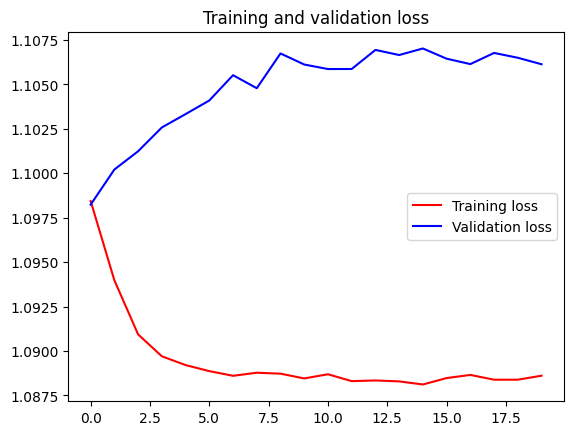

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

## Previsões

In [ ]:
loss,accuracy = model.evaluate(x_test, y_test, batch_size=32)

20/20 [==============================] - 0s 8ms/step - loss: 1.1047 - accuracy: 0.3508


In [ ]:
train_predict_probs = model.predict(x_train)
val_predict_probs = model.predict(x_val)
test_predict_probs = model.predict(x_test)

train_predict = np.argmax(train_predict_probs, axis=1)
val_predict = np.argmax(val_predict_probs, axis=1)
test_predict = np.argmax(test_predict_probs, axis=1)

print(train_predict.shape, val_predict.shape, test_predict.shape)
print(train_predict)

20/20 [==============================] - 0s 5ms/step
(2136,) (305,) (610,)
[2 2 2 ... 2 2 2]


In [ ]:
train_predict_probs

array([[0.3387776 , 0.2740084 , 0.387214  ],
       [0.3387776 , 0.2740084 , 0.38721403],
       [0.33877757, 0.2740083 , 0.38721403],
       ...,
       [0.33877343, 0.27406427, 0.38716227],
       [0.3387734 , 0.27406454, 0.38716206],
       [0.33877334, 0.2740659 , 0.38716084]], dtype=float32)

In [ ]:
conf_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predict)
conf_matrix

array([[  0,   0, 197],
       [  0,   0, 199],
       [  0,   0, 214]])

Plotar o Gráfico